In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import random
from PIL import Image

import torch
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

In [3]:
annotations = pd.read_csv('data/annotations.csv')
annotations

,filename,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,000000289343.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000000061471.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000000472375.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000000520301.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000000579321.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4947,000000386134.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4948,000000097585.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4949,000000429530.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4950,000000031749.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
len(annotations.columns)

81

# CustomDataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annotations, transforms):
        super().__init__()
        self.data = []
        self.root_path = root_path
        self.transforms = transforms
        l = annotations.shape[0]

        for i in range(l):
            img = annotations.iloc[i, 0]
            classes = annotations.iloc[i, 1:].tolist()
            self.data.append((img, classes))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.data[idx][0])
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        label = torch.tensor(self.data[idx][1]).to(torch.float)

        return img, label

In [6]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/6/data/images', annotations, transforms)

In [7]:
len(total_dataset[0][1])

80

In [8]:
classes = annotations.columns.tolist()[1:]
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

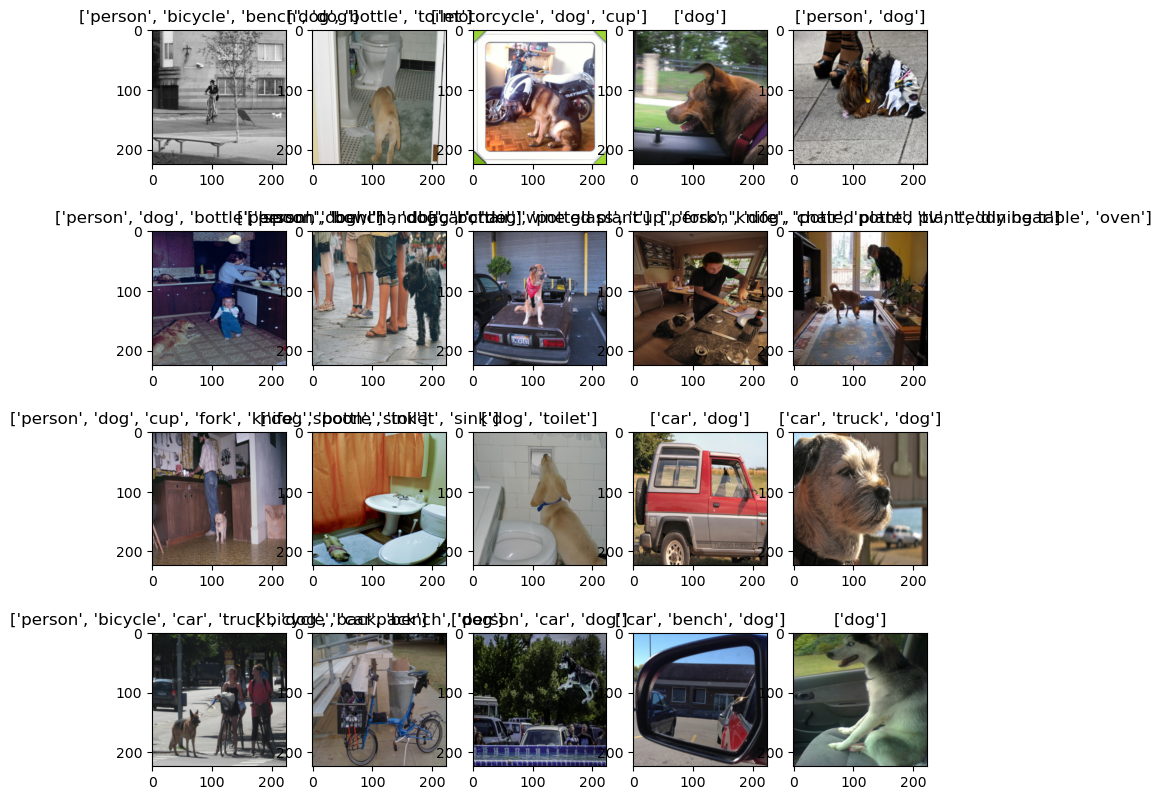

In [9]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_dataset[i][0].permute(1, 2, 0))
    cls_list = total_dataset[i][1].tolist()
    labels = []
    for j in range(len(cls_list)):
        if cls_list[j] == 1:
            labels.append(classes[j])

    plt.title(labels)

In [10]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)
print(train_num, valid_num, test_num)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

3961 495 495


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# train, eval

In [12]:
def training(model, train_dataloader, criterion, optimizer, threshold):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = (torch.sigmoid(outputs)>threshold).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs)>threshold).float()

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    train_loss_list = []
    train_f1_list = []
    valid_loss_list = []
    valid_f1_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold)

        train_loss_list.append(train_loss)
        train_f1_list.append(train_f1)
        valid_loss_list.append(valid_loss)
        valid_f1_list.append(valid_f1)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list

# model

In [13]:
model = models.resnet50(pretrained=True)
model

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(in_features=2048, out_features=len(classes))

for param in model.fc.parameters():
    param.requires_grad = True

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list = training_loop(model, train_dataloader ,valid_dataloader, criterion, optimizer, 0.5, 10)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.17402294501662255, Train F1: 0.023298268936446584, Valid Loss: 0.12207146286964417, Valid F1: 0.012801709013453635


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.10636868011206388, Train F1: 0.04731313123020091, Valid Loss: 0.09700250327587127, Valid F1: 0.11019294621642728


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.09089943133294583, Train F1: 0.16435269224342022, Valid Loss: 0.08803043365478516, Valid F1: 0.2132663206521525


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.08257145006209612, Train F1: 0.26621562773468704, Valid Loss: 0.08297867774963379, Valid F1: 0.2976592740779725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.07752924244850874, Train F1: 0.332902140887967, Valid Loss: 0.0803131639957428, Valid F1: 0.3244020591235232


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.07364293020218611, Train F1: 0.3841433452352494, Valid Loss: 0.07793809324502946, Valid F1: 0.36968777616127424


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.07075731744989752, Train F1: 0.4268297306696354, Valid Loss: 0.07727698385715484, Valid F1: 0.4008284920400481


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.06871445393189787, Train F1: 0.45746277547342046, Valid Loss: 0.07706345468759537, Valid F1: 0.39824160421483584


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.06686397176235914, Train F1: 0.4825147243792712, Valid Loss: 0.07580550760030746, Valid F1: 0.4184156702060616


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.06490489225834609, Train F1: 0.4991537144695751, Valid Loss: 0.0751263976097107, Valid F1: 0.4339758032689037


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


# test

In [23]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='macro'))

  0%|          | 0/5 [00:00<?, ?it/s]

0.4511911055856565


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [27]:
for i in range(20):
    print(f'True: {test_dataset[i][1].numpy()}\nPred: {total_preds[i]}')
    print()

True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.]

True: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.